In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage
from skimage.external import tifffile
from skimage import filters
from skimage.exposure import rescale_intensity
from skimage import feature
from sklearn.decomposition import PCA

matplotlib.rcParams['figure.figsize'] = (15, 7)

In [124]:
labels = pd.read_csv('/Users/sean/Desktop/Results.csv', usecols=[1]).values.ravel()
images = np.nan_to_num(tifffile.imread('proc_data/r_410_470_big.tif'))
bin_410 = tifffile.imread('proc_data/bin_all_410_big.tif')
im_410 = np.nan_to_num(tifffile.imread('proc_data/all_410_big.tif'))
im_470 = np.nan_to_num(tifffile.imread('proc_data/all_470_big.tif'))

In [125]:
np.shape(im_470)

(1198, 50, 75)

In [126]:
def norm(img):
    return (img - np.mean(img)) / np.std(img)

In [134]:
hog_feats = np.asarray([feature.hog(img, feature_vector=True, block_norm='L2-Hys') for img in images])

In [135]:
pd.DataFrame(hog_feats).to_csv('/Users/sean/Desktop/hogs.csv', index=None)

In [136]:
pd.DataFrame(hog_feats).shape

(1198, 2268)

In [130]:
np.shape(hog_feats)

(1198, 2268)

# Center of Mass Features

In [ ]:
def com_per_col(img):
    n = img.shape[0]
    i = np.arange(n).reshape([n, 1])
    return np.sum(img * i, axis=0) / np.sum(img, axis=0)

def center_of_mass_dy(im, dY):
    h = im.shape[0]
    offset = np.arange(h).reshape(h,1)
    
    slice_idx = np.minimum(list(zip(np.arange(0,h), np.arange(0,h) + dY)), h) # [[0,3], [1,4], [2,5]...]
    all_coms = []
    for s in slice_idx:
        I = im[s[0]:s[1]]
        coms = com_per_col(I)
        all_coms.append(coms)
    return np.vstack(all_coms) + offset

def center_of_mass_dx(im, dX):
    im = np.transpose(im)
    return center_of_mass_dy(im, dX)

In [ ]:
def com_dy_plot(idx, com_dy_410_, com_dy_470_, ax=None):
    if not ax:
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
    for i in range(images[idx].shape[0]):
        ax.imshow(images[idx])
        _=ax.plot(com_dy_410_[idx][i], linewidth=2, c='red', linestyle='-')
        _=ax.plot(com_dy_470_[idx][i], linewidth=2, c='black', linestyle='-')
    return fig

def com_dx_plot(idx, com_dy_410_, com_dy_470_, ax=None):
    if not ax:
        fig = plt.figure(figsize=(15,10))
        ax = fig.gca()
    for i in range(images[idx].shape[1]):
        ax.imshow(np.transpose(images[idx]))
        _=ax.plot(com_dy_410_[idx][i], linewidth=2, c='red', linestyle='-')
        _=ax.plot(com_dy_470_[idx][i], linewidth=2, c='black', linestyle='-') 
    return fig

def SE_plot(com_410_, com_470_, labels, title=None):
    unique_labels = np.unique(labels)
    n_labels = len(unique_labels)
    
    fig, axes = plt.subplots(n_labels + 1, sharey=False, figsize=(10, 15))
    
    for j, L in enumerate(unique_labels):
        SE_L = np.asarray([np.sum(np.square(com_410_[i] - com_470_[i]), axis=0) for i in np.where(labels == L)[0]])
        axes[n_labels].plot(np.mean(SE_L, axis=0), label=L)
        
        for i in range(len(SE_L)):
            axes[j].plot(SE_L[i])
            axes[j].set_title('Label ' + str(L))
    axes[n_labels].legend()
    axes[n_labels].set_title('Mean')
    if title:
        fig.suptitle(title)
    fig.tight_layout()
    return fig

In [112]:
dY = 9
com_dy_410 = np.nan_to_num(np.asarray([center_of_mass_dy(im, dY) for im in im_410]))
com_dy_470 = np.nan_to_num(np.asarray([center_of_mass_dy(im, dY) for im in im_470]))

dX = 10
com_dx_410 = np.nan_to_num(np.asarray([center_of_mass_dx(im, dX) for im in im_410]))
com_dx_470 = np.nan_to_num(np.asarray([center_of_mass_dx(im, dX) for im in im_470]))

/Users/sean/.virtualenvs/wormAnalysis/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


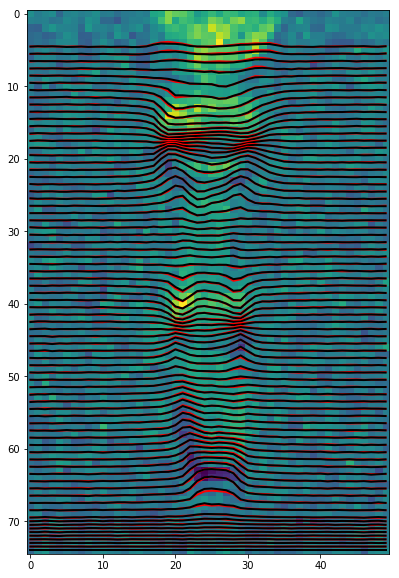

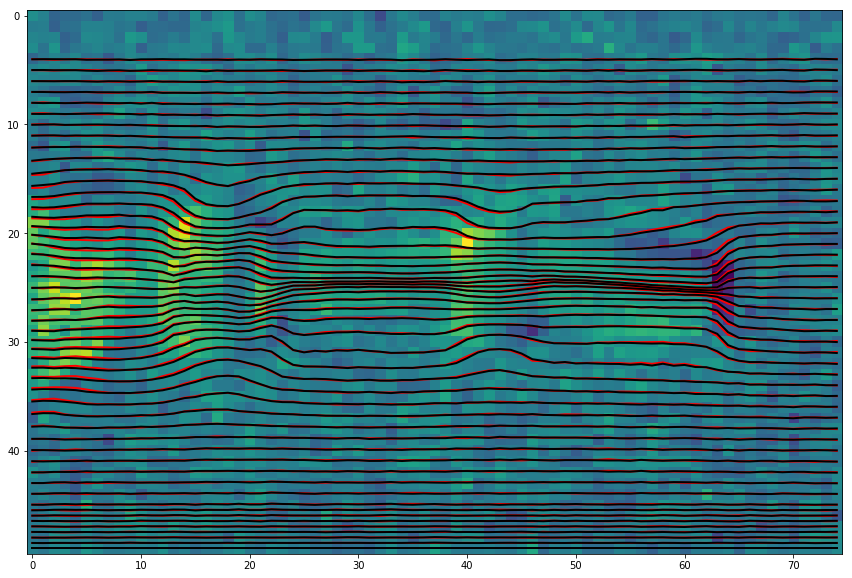

In [113]:
fig_com_dx = com_dx_plot(0, com_dx_410, com_dx_470)
fig_com_dy = com_dy_plot(0, com_dy_410, com_dy_470)

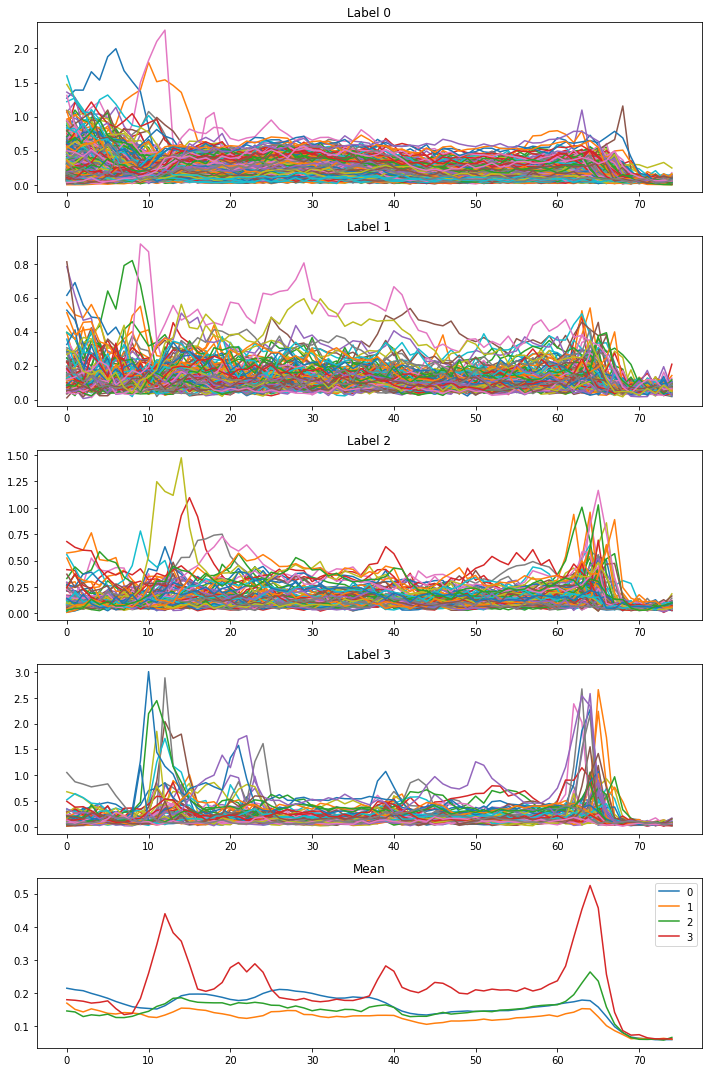

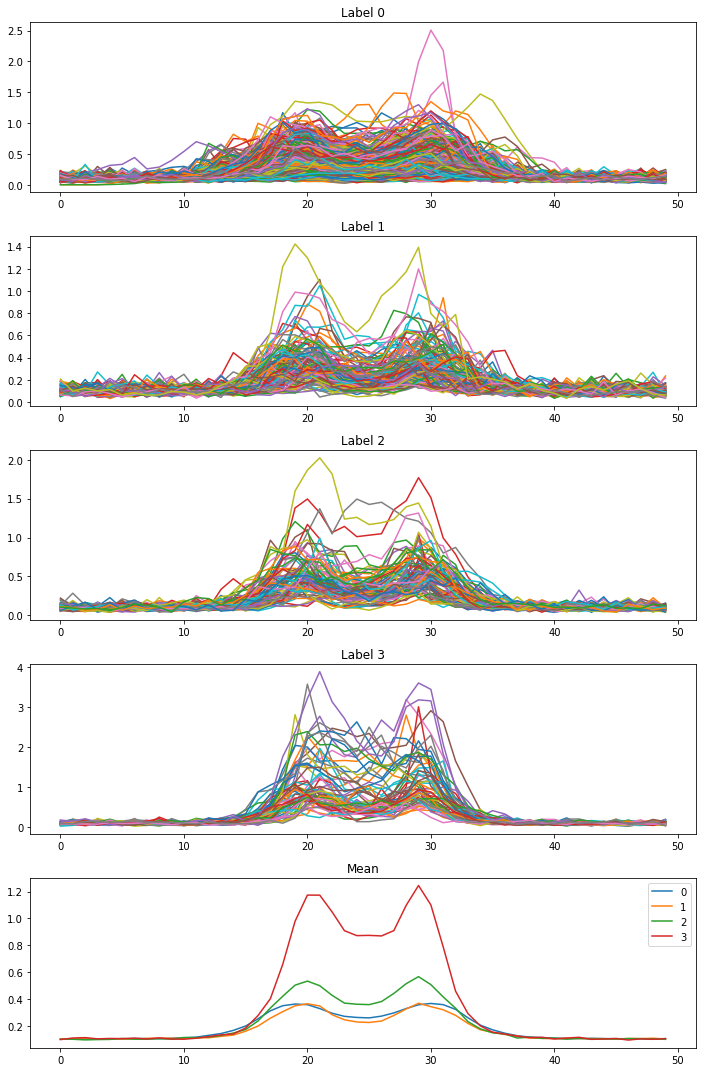

In [114]:
fig_dy = SE_plot(com_dy_410, com_dy_470, labels)
fig_dy.savefig('/Users/sean/Desktop/dY.pdf')

fig_dx = SE_plot(com_dx_410, com_dx_470, labels)
fig_dx.savefig('/Users/sean/Desktop/dX.pdf')

In [115]:
def sum_squared_errors(com_410_, com_470_):
    return np.asarray([np.sum(np.square(com_410_[i] - com_470_[i]), axis=0) for i in range(len(com_410_))])

In [116]:
sse_dx = sum_squared_errors(com_dx_410, com_dx_470)
sse_dy = sum_squared_errors(com_dy_410, com_dy_470)

Text(0.5,1,'Variance of Features')

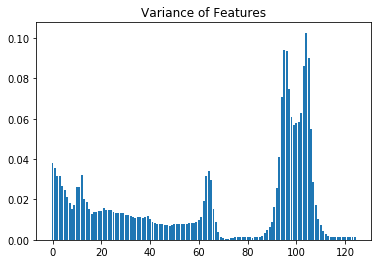

In [117]:
variances = np.var(np.concatenate((sse_dy, sse_dx), axis=1), axis=0)
plt.bar(np.arange(len(variances)), variances)
plt.gca().set_title('Variance of Features')

Text(0.5,1,'Mean of Features')

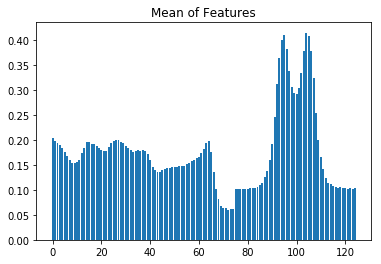

In [118]:
means = np.mean(np.concatenate((sse_dy, sse_dx), axis=1), axis=0)
plt.bar(np.arange(len(means)), means)
plt.gca().set_title('Mean of Features')

In [119]:
com_feats = np.concatenate((sse_dy, sse_dx), axis=1)

In [120]:
np.shape(com_feats)

(1198, 125)

In [121]:
np.savetxt('/Users/sean/Desktop/com_feats.csv', com_feats, delimiter=',')

In [122]:
pca = PCA(n_components=2)
X_r = pca.fit(com_feats).transform(com_feats)

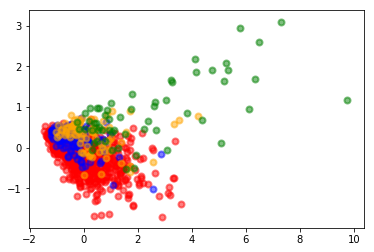

In [123]:
y = labels
lw = 2
for color, i, target_name in zip(['red', 'blue', 'orange', 'green'], [0, 1, 2, 3], ['0', '1', '2', '3']):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=.5, lw=lw,
                label=target_name)

In [43]:
from sklearn import svm
clf = svm.SVC()
clf.fit(com_feats, labels)

clf.score(com_feats, labels)

0.7998331943286072

## Improving CoM Features

One problem is that we lose a lot of spatial information when we take the mean of the entire column, so instead, maybe we can look at chunks of columns of these CoM matrices (visualized below as chunk A, B, C)

We can take the Sum of the Squared errors inside that chunk as a feature

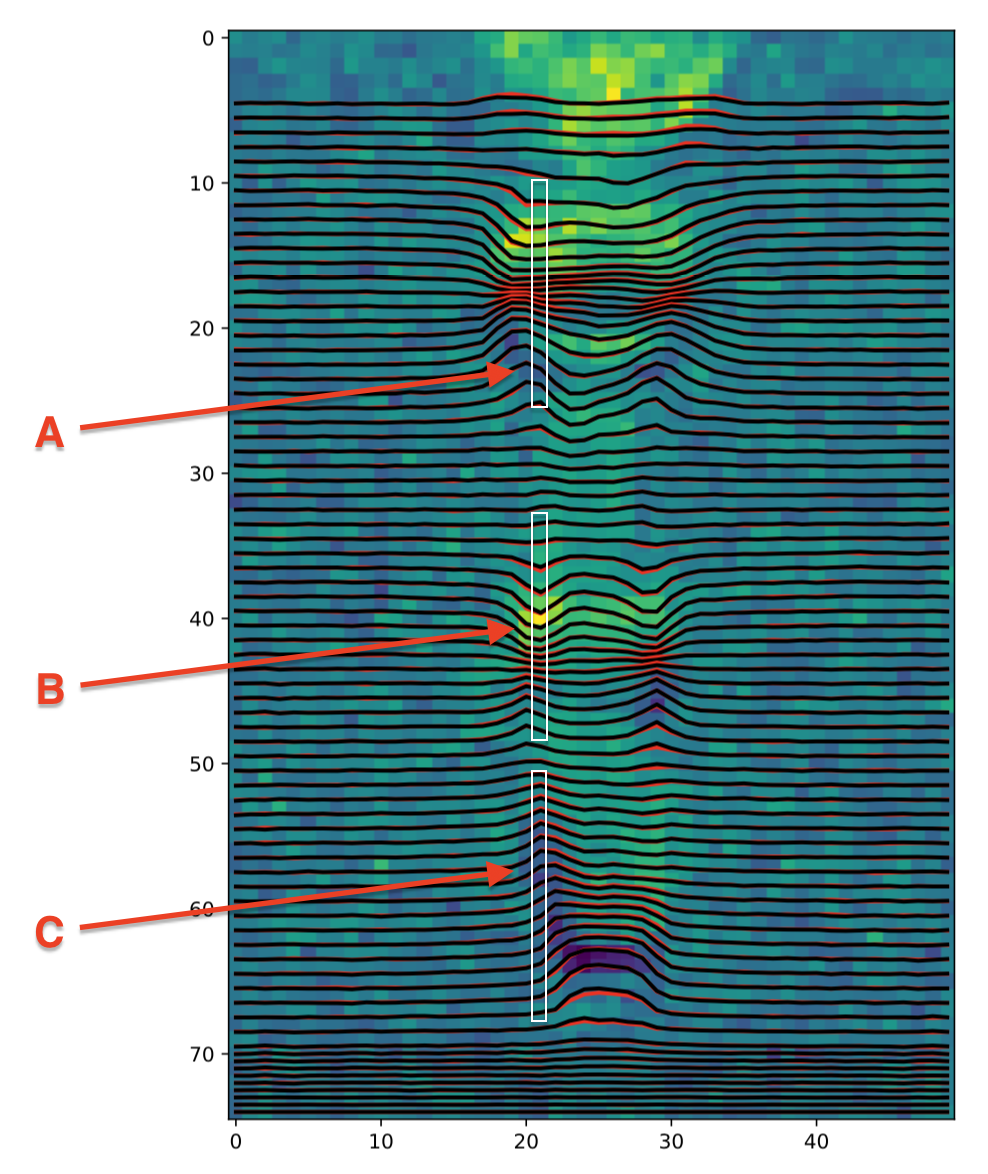

In [ ]:
fig_com_dy = com_dy_plot(905, com_dy_410, com_dy_470)

In [ ]:
im = images[6]
scaled = rescale_intensity(im, in_range='image', out_range=(-1,1))

plt.imshow(skimage.transform.resize(scaled[17:33,10:65], (50, 100)))

In [ ]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def rescale(im, bin_img):
    bb = bbox(bin_img)
    return skimage.transform.resize(im[bb[0]:bb[1]+1,bb[2]:bb[3]+1], (20, 100), mode='reflect')

In [ ]:
idx = 0
bb = bbox(bin_410[idx])
scaled = rescale_intensity(im_410[idx], in_range='image', out_range=(-1,1))
fig, axes = plt.subplots(2,1)
axes[0].imshow(rescale(im_410[idx], bin_410[idx]))
axes[1].imshow(rescale(im_470[idx], bin_410[idx]))

In [ ]:
scaled_ratios = np.asarray([rescale(im_410[idx], bin_410[idx]) / rescale(im_470[idx], bin_410[idx]) for idx in range(len(im_410))], dtype=np.float32)

In [ ]:
plt.imshow(im_410[775])